In [211]:
import xarray as xr
import os, sys
import pandas as pd
import cftime
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# Preliminary steps

## Functions

In [212]:
def read_csv(file_path, filename, varname):
    """
    Reads a CSV file, skips the first line and converts into into xarray.
    """
    ds = pd.read_csv(file_path+filename, skiprows=1, header=None, names=['time', varname], na_values=['NaN',-9999])
    ds['time'] = pd.to_datetime(ds['time'], format='%Y-%m-%d')

    ds = ds.set_index('time')
    ds = ds.to_xarray()
    ds['time'] = ds['time'].astype('datetime64[ns]')
    ds[varname] = ds[varname].astype('float32')

    return ds

In [213]:
def read_csv2(filepath):
    """
    Reads a CSV file and converts it to an xarray Dataset.
    """

    df = pd.read_csv(filepath, sep=';', skipinitialspace=True)
    
    df.columns = ['time', 'q']
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d')
    df.set_index('time', inplace=True)
    ds = df.to_xarray()
    
    return ds

In [214]:
def signif(index1, index2, lag):
    from scipy.stats import t

    # Calculate correlations
    r = np.corrcoef(index1, index2)[0, 1]
    r1 = np.corrcoef(index1[:-lag], index2[lag:])[0, 1]
    r2 = np.corrcoef(index1[lag:], index2[:-lag])[0, 1]

    N = len(index1)
    DOF = N * (1 - r1 * r2) / (1 + r1 * r2)
    t_par = np.abs(r * np.sqrt(DOF - 2) / np.sqrt(1 - r**2))
    significance = (1 - 2 * t.sf(t_par, DOF)) * 100

    return significance

In [215]:
def anom(xarr):
    #monthly mean anomaly (No-detrened)

    xarr_clm = xarr.groupby('time.month').mean('time')
    xarr_ano = xarr.groupby('time.month') - xarr_clm
    return xarr_ano, xarr_clm

## Open dataset

In [216]:
path = '/home/amnd25/Desktop/Milano/Test_CDP_PhD/'

dmi = read_csv(path,'dmi.had.long.csv','dmi')
mei = read_csv(path,'mei.ext.long.csv','mei') # multivariate ENSO index
nao = read_csv(path,'nao.long.csv','nao')
nino3 = read_csv(path,'nino3.long.anom.csv','nino3')
nino4 = read_csv(path,'nino4.long.anom.csv','nino4')
nino12 = read_csv(path,'nino12.long.anom.csv','nino12')
nino34 = read_csv(path,'nino34.long.anom.csv','nino34')
pdo = read_csv(path,'pdo.timeseries.sstens.csv','pdo') # Pacific Decadal Oscillation
soi = read_csv(path,'soi.long.csv','soi') # Southern Oscillation Index
tsa = read_csv(path,'tsa.long.csv','tsa') # Tropical Southern Atlantic

data_names = ['dmi', 'mei', 'nao', 'nino3', 'nino4', 'nino12', 'nino34', 'pdo', 'soi', 'tsa'] # 10 climate indices
data_list =[dmi, mei, nao, nino3, nino4, nino12, nino34, pdo, soi, tsa]

### Streamflow

In [217]:
streamflow = read_csv2(path+'Zambezi_at_BigTree_VicFalls_obs_discharge.txt')

In [218]:
streamflow

<xarray.Dataset> Size: 548kB
Dimensions:  (time: 34252)
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11
Data variables:
    q        (time) float64 274kB 100.0 100.0 100.0 ... 1.635e+03 1.587e+03

In [219]:
streamflow_anom, streamflow_clm = anom(streamflow.q)

In [220]:
rolling_mean_3 = streamflow_anom.rolling(time=3, center=True).mean() # mean anomaly over 3 months

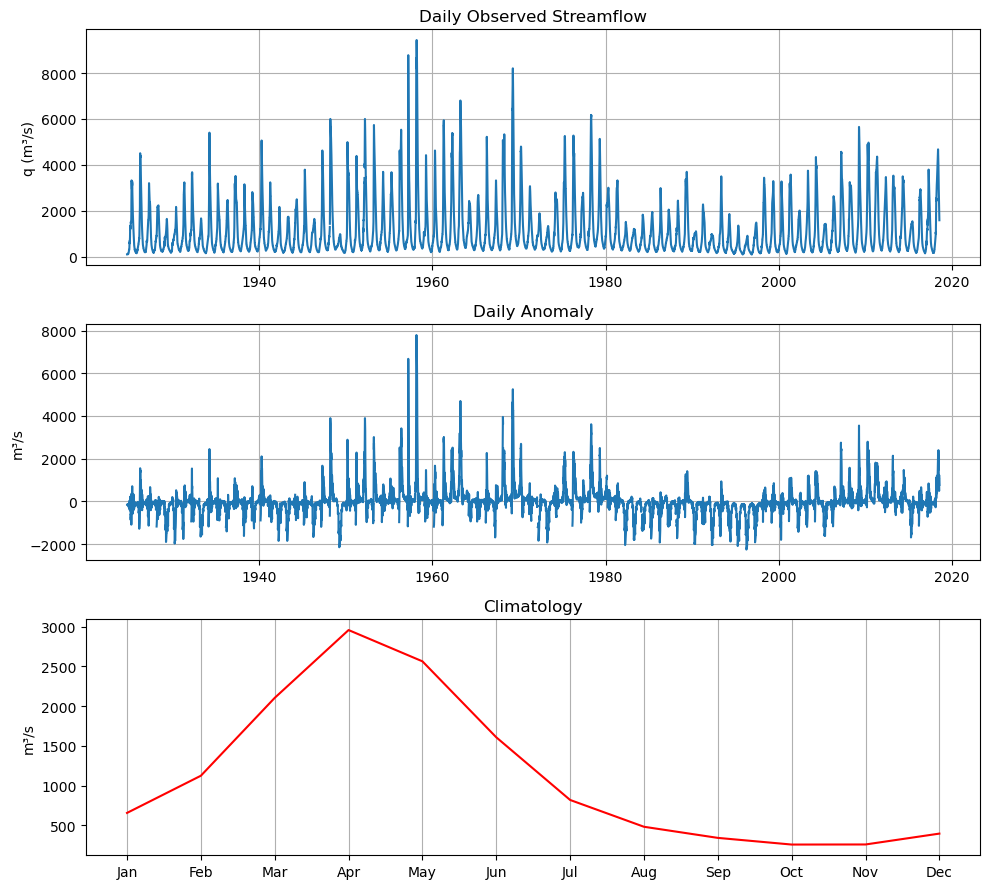

In [221]:
fig, ax = plt.subplots(figsize=(10, 9), nrows=3, ncols=1)

ax[0].plot(streamflow.time, streamflow.q, label='Observed Streamflow')
ax[1].plot(streamflow_anom.time, streamflow_anom, label='Anomaly')
ax[2].plot(streamflow_clm, color='red', label='Climatology')

ax[0].set_title('Daily Observed Streamflow')
ax[1].set_title('Daily Anomaly')
ax[2].set_title('Climatology')

ax[0].set_ylabel('q (m³/s)')    
ax[1].set_ylabel('m³/s')
ax[2].set_ylabel('m³/s')

ax[0].grid()
ax[1].grid()
ax[2].grid(axis='x')  # Solo griglia verticale

# Etichette dei mesi su x per il terzo subplot
ax[2].set_xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()


In [222]:
monthly_streamflow = streamflow.resample(time='M').mean()  # Resample to monthly mean
monthly_streamflow_anom = streamflow_anom.resample(time='M').mean() 

/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


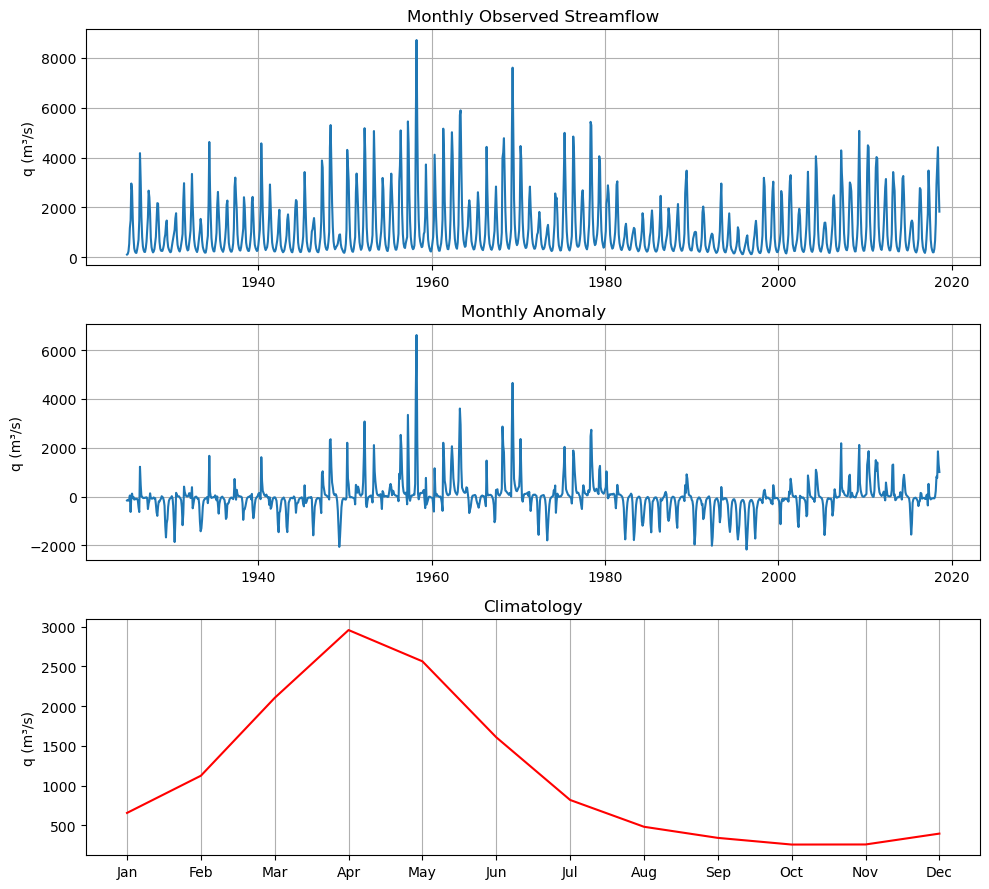

In [223]:
fig, ax = plt.subplots(figsize=(10, 9), nrows=3, ncols=1)

ax[0].plot(monthly_streamflow.time, monthly_streamflow.q, label='Observed Streamflow')
ax[1].plot(monthly_streamflow_anom.time, monthly_streamflow_anom, label='Anomaly')
ax[2].plot(streamflow_clm, color='red', label='Climatology')

ax[0].set_title('Monthly Observed Streamflow')
ax[1].set_title('Monthly Anomaly')
ax[2].set_title('Climatology')

ax[0].set_ylabel('q (m³/s)')    
ax[1].set_ylabel('q (m³/s)')
ax[2].set_ylabel('q (m³/s)')

ax[0].grid()
ax[1].grid()
ax[2].grid(axis='x')  # Solo griglia verticale

# Etichette dei mesi su x per il terzo subplot
ax[2].set_xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()

### Climate Indices

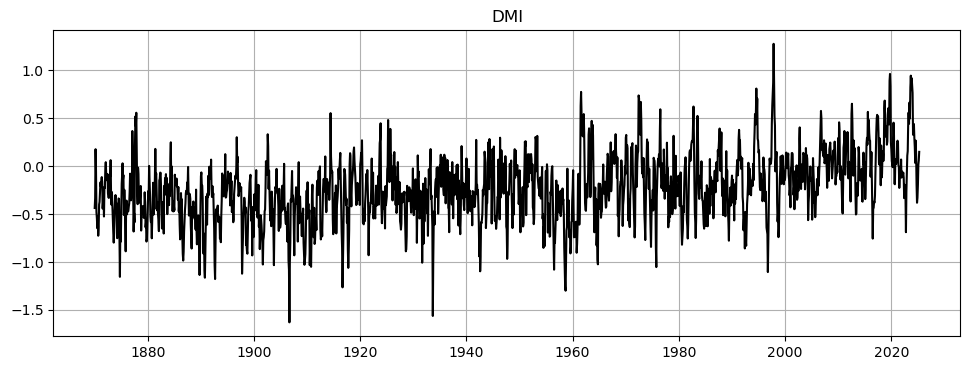

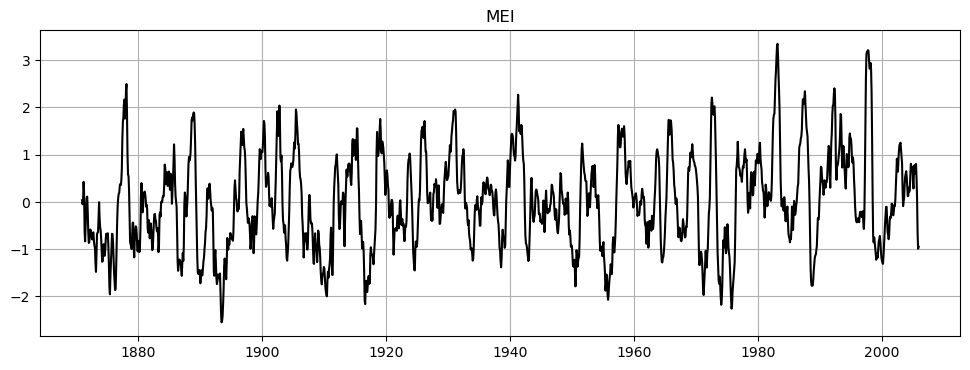

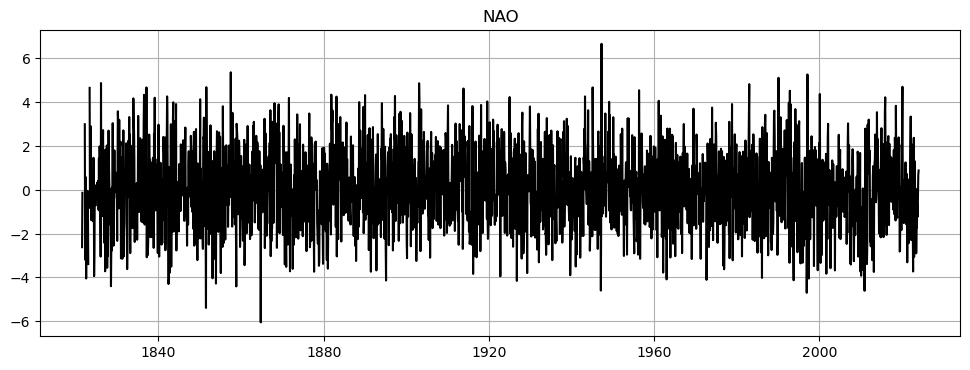

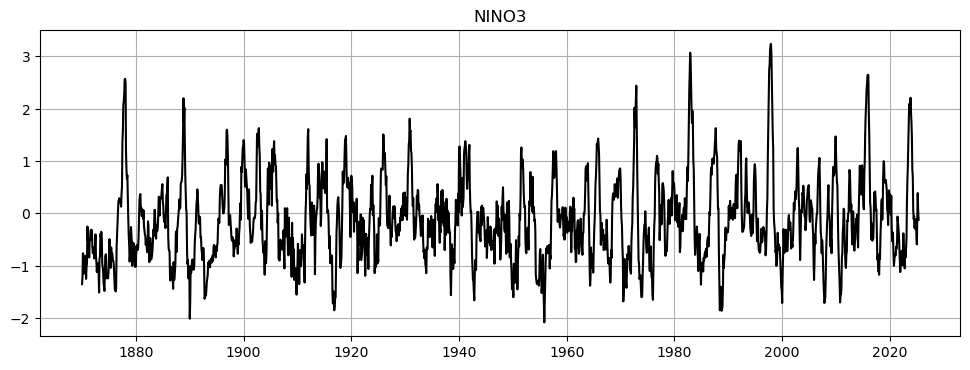

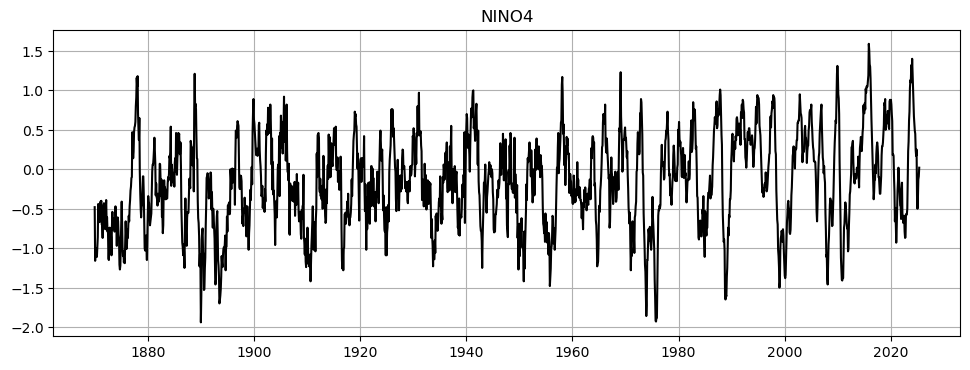

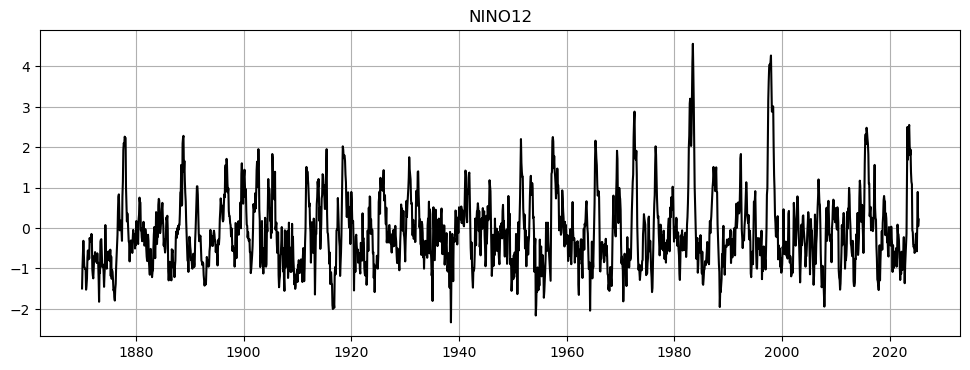

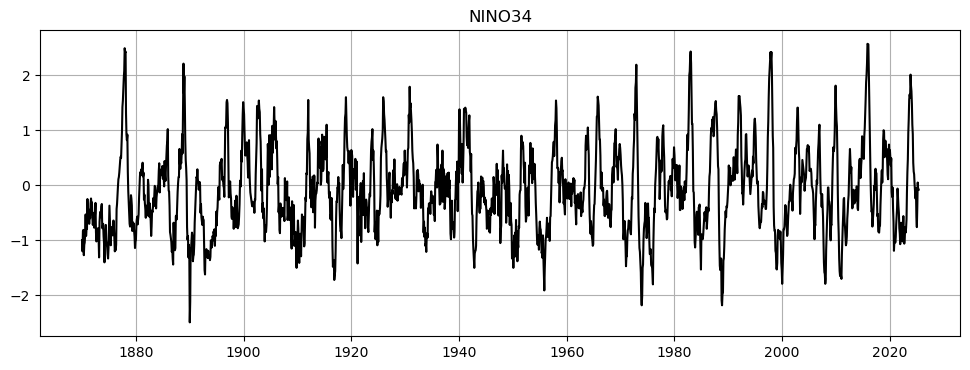

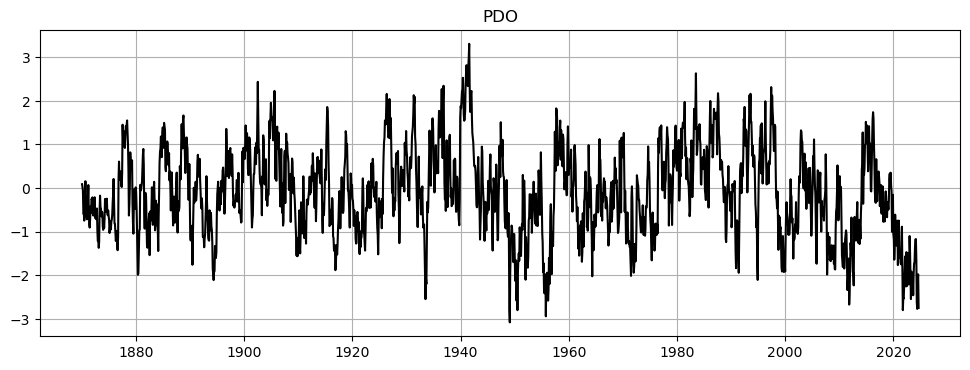

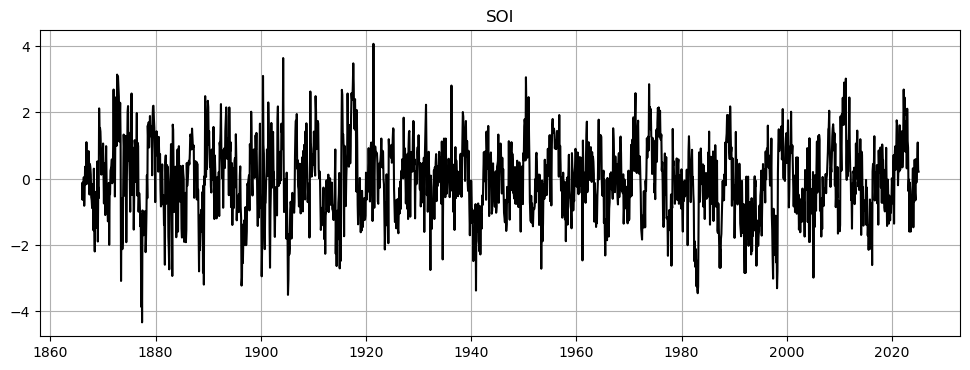

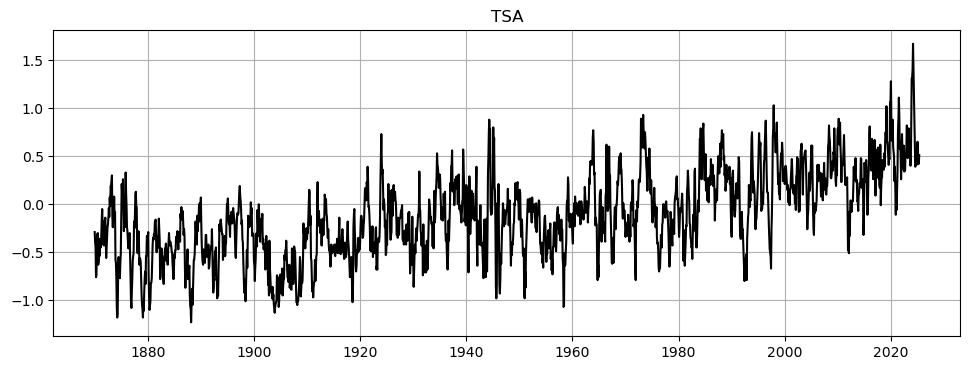

In [224]:
for name, ds in zip(data_names, data_list):
    var = ds[name]  # accede alla variabile interna con lo stesso nome
    plt.figure(figsize=(10, 4))
    var.plot(color='black')
    plt.title(name.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.xlabel('')
    plt.ylabel('')

# Data analysis

### Data

In [225]:
streamflow

<xarray.Dataset> Size: 548kB
Dimensions:  (time: 34252)
Coordinates:
  * time     (time) datetime64[ns] 274kB 1924-10-01 1924-10-02 ... 2018-07-11
Data variables:
    q        (time) float64 274kB 100.0 100.0 100.0 ... 1.635e+03 1.587e+03

In [226]:
dmi

<xarray.Dataset> Size: 22kB
Dimensions:  (time: 1872)
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-01 1870-02-01 ... 2025-12-01
Data variables:
    dmi      (time) float32 7kB -0.438 -0.336 0.177 -0.048 ... nan nan nan nan

## Analysis

In [227]:
import pymannkendall as mk

result = mk.original_test(streamflow_anom.resample(time='YE').mean())
print('Mann-Kendall test result:', result)

Mann-Kendall test result: Mann_Kendall_Test(trend='no trend', h=False, p=0.4914342730437269, z=0.6880293911632612, Tau=0.048152295632698766, s=215.0, var_s=96741.66666666667, slope=1.0311643835616475, intercept=-79.52085893699821)


### Composite analysis over extremes

In [228]:
streamflow_anom = streamflow_anom.resample(time='M').mean() # Monthly resampling to reduce noise and find trends
streamflow_series = streamflow_anom.to_series().dropna()

q90 = streamflow_series.quantile(0.9) # High extreme
q10 = streamflow_series.quantile(0.1) # Low extreme

extreme_high = streamflow_series[streamflow_series > q90]
extreme_low = streamflow_series[streamflow_series < q10]

/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


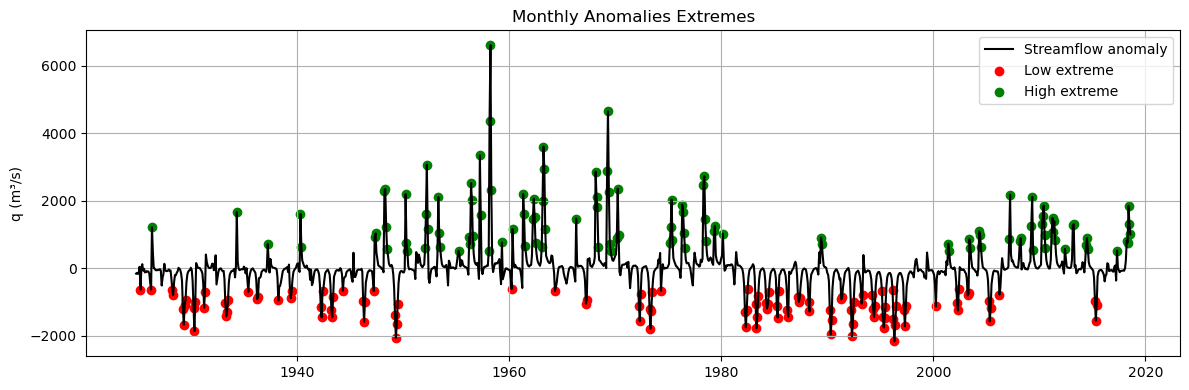

In [229]:
plt.figure(figsize=(12, 4))
plt.plot(streamflow_series, label='Streamflow anomaly', color='black')

plt.scatter(extreme_low.index, extreme_low.values, color='red', label='Low extreme')
plt.scatter(extreme_high.index, extreme_high.values, color='green', label='High extreme')

plt.title("Monthly Anomalies Extremes")
plt.ylabel("q (m³/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [230]:
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

In [231]:
composites_high = {} # Composites analysis
composites_low = {}
significance_dict = {}

for i, ds in enumerate(data_list_time_cropped):
    nome = data_names[i]
    climate_index = ds[nome].to_series()

    climate_index.index = climate_index.index.to_period('M') # Make sure that they are monthly
    streamflow_idx_period = streamflow_series.index.to_period('M') # Build a period index for streamflow for correlation
    high_extreme_period = high_extreme_dates.to_period('M')
    low_extreme_period = low_extreme_dates.to_period('M')

    climate_index = climate_index.reindex(streamflow_idx_period) # Reindex does not change the index, just aligns it

    high_vals = climate_index.loc[climate_index.index.isin(high_extreme_period)] # Extract values during extremes
    low_vals = climate_index.loc[climate_index.index.isin(low_extreme_period)]

    composites_high[nome] = high_vals.mean() # Composites analysis for high extremes
    composites_low[nome] = low_vals.mean() # Composites analysis for low extremes


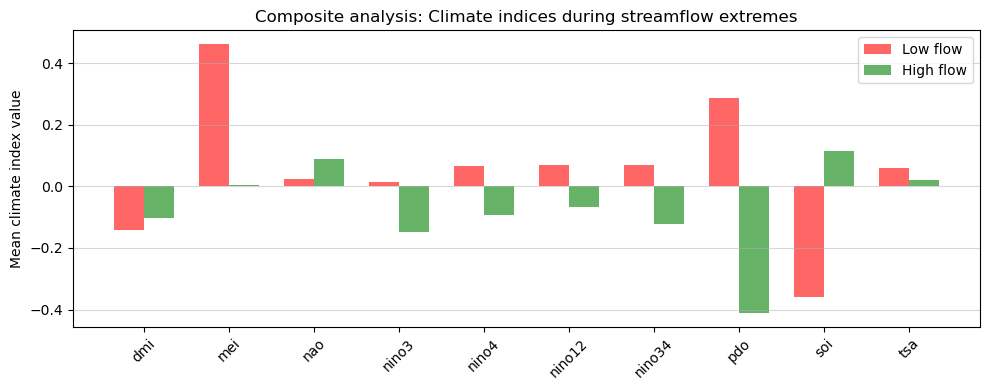

In [232]:
labels = list(composites_high.keys())
high_means = [composites_high[k] for k in labels]
low_means = [composites_low[k] for k in labels]
#signif_vals = [significance_dict[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, low_means, width, label='Low flow', color='red', alpha=0.6)
plt.bar(x + width/2, high_means, width, label='High flow', color='green', alpha=0.6)

plt.xticks(x, labels, rotation=45)
plt.ylabel('Mean climate index value')
plt.title('Composite analysis: Climate indices during streamflow extremes')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.5)

#for i, val in enumerate(signif_vals):
#    if not np.isnan(val):
#        plt.text(x[i] + width/2, high_means[i] + 0.01,
#                 f'p={val:.2g}',
#                 ha='center', va='bottom', fontsize=8, color='black')

### Ruptures

In [233]:
streamflow_series = streamflow_anom.resample(time='M').mean().to_series().dropna()

signal = streamflow_series.values.reshape(-1, 1) # Need to reshape for ruptures (2D array)

algo = rpt.Pelt(model="rbf").fit(signal) # Ruptures algorithm for change point detection
breaks = algo.predict(pen=10) # To find change points in the streamflow anomaly series

/home/amnd25/anaconda3/envs/milano/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


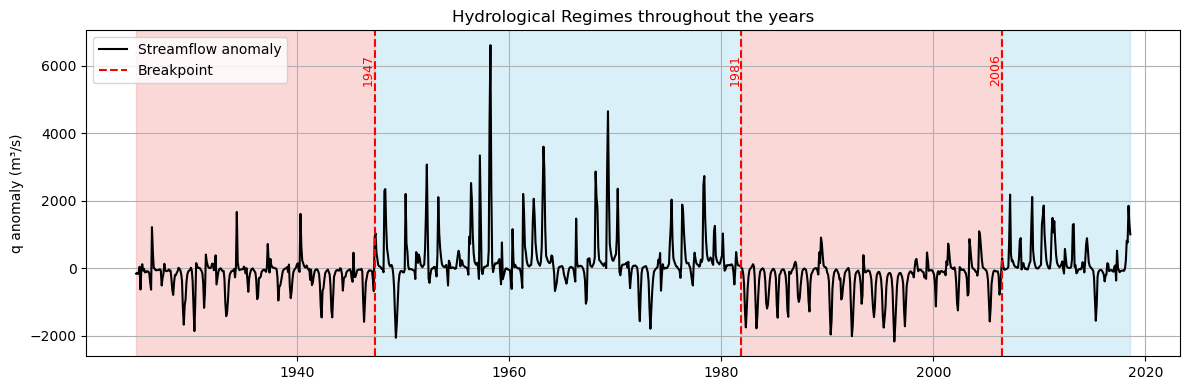

In [234]:
plt.figure(figsize=(12, 4))
plt.plot(streamflow_series.index, streamflow_series.values, label='Streamflow anomaly', color='black')

colors = ['lightcoral', 'skyblue'] 
all_breaks = [0] + breaks # To include the start of the series

for i in range(len(all_breaks) - 1):
    start_idx = all_breaks[i]
    end_idx = all_breaks[i + 1]
    start_date = streamflow_series.index[start_idx]
    end_date = streamflow_series.index[end_idx - 1] if end_idx < len(streamflow_series) else streamflow_series.index[-1]

    plt.axvspan(start_date, end_date, color=colors[i % 2], alpha=0.3)

for i, bkpt in enumerate(breaks[:-1]): # Vertical line for breakpoints
    bkpt_date = streamflow_series.index[bkpt]
    plt.axvline(bkpt_date, color='red', linestyle='--', label='Breakpoint' if i == 0 else "")
    plt.text(bkpt_date, plt.ylim()[1]*0.9, str(bkpt_date.year),
             rotation=90, color='red', fontsize=9, ha='right', va='top')

plt.title("Hydrological Regimes throughout the years")
plt.ylabel("q anomaly (m³/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Correlation

In [235]:
data_list_time_cropped = [ds.sel(time=slice('1924-10-01', '2018-07-11')) for ds in data_list]

/tmp/ipykernel_6362/1317682182.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


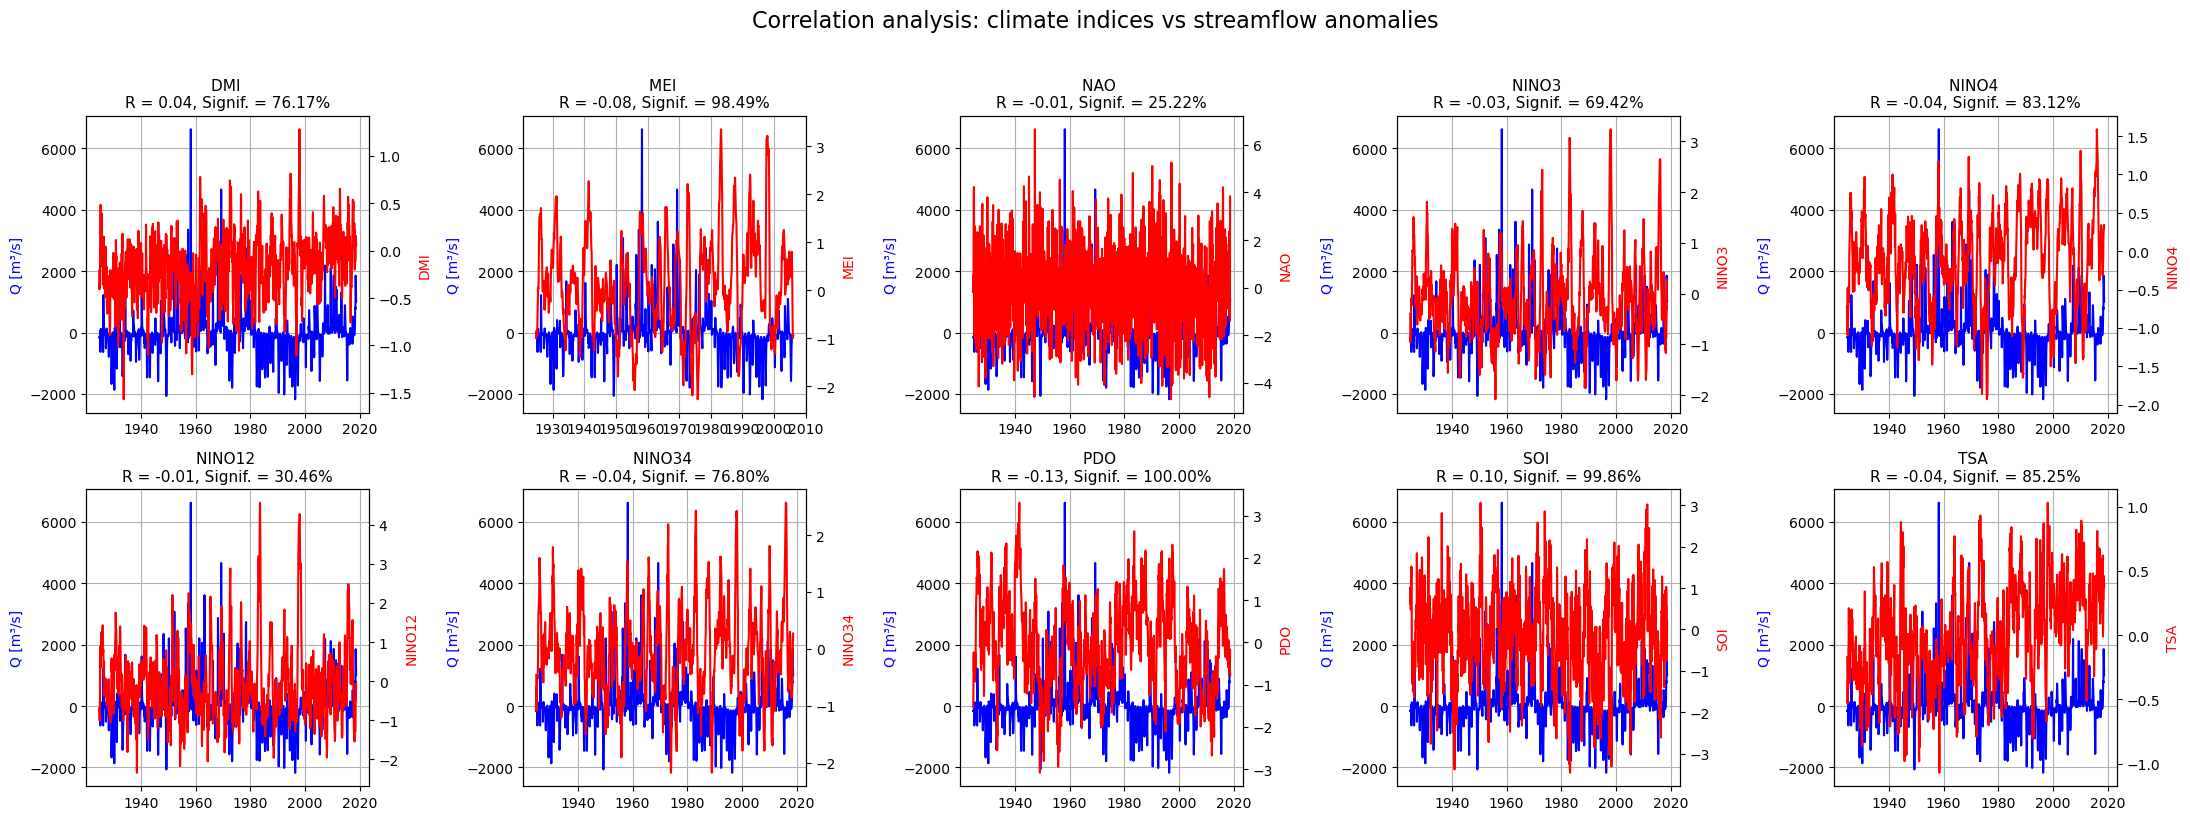

In [236]:
monthly_streamflow = streamflow_anom.resample(time='1ME').mean('time') # Resample streamflow to monthly values 

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(22, 8), sharex=False, constrained_layout=True)
axs = axs.flatten()

for i, (name, data) in enumerate(zip(data_names, data_list_time_cropped)):
    
    clim = data[name].resample(time='1ME').mean('time') # Make sure climate indices are also monthly
    
    q_aligned, clim_aligned = xr.align(monthly_streamflow, clim, join='inner') # Align the time indices of streamflow and climate indices
    
    corr = np.corrcoef(q_aligned, clim_aligned)[0, 1]
    significance = signif(q_aligned, clim_aligned, lag=1)
    
    axs[i].plot(q_aligned.time, q_aligned, color='blue', label='Streamflow')
    axs[i].set_ylabel("Q [m³/s]", color='blue', fontsize=10)
    ax2 = axs[i].twinx()
    ax2.plot(clim_aligned.time, clim_aligned, color='red', label=name.upper())
    ax2.set_ylabel(name.upper(), color='red', fontsize=10)
    axs[i].set_title(f"{name.upper()} \nR = {corr:.2f}" f", Signif. = {significance:.2f}%", fontsize=11)

for ax in axs:
    ax.grid(True)

plt.suptitle("Correlation analysis: climate indices vs streamflow anomalies", fontsize=16, y=1.02)
plt.tight_layout()

### Lagged correlation

In [237]:
lag_list = [1, 2, 3, 4, 5, 6]

monthly_streamflow = streamflow_anom.resample(time='MS').mean('time')
streamflow_q = monthly_streamflow

df_corr_anom = pd.DataFrame(index=lag_list, columns=data_names, dtype=float) # Initialize DataFrame for all lags and climate indices
df_pval_anom = pd.DataFrame(index=lag_list, columns=data_names, dtype=float) # Initialize DataFrame for p-values

for i, ds in enumerate(data_list_time_cropped):
    nome = data_names[i]

    climate_index = ds[nome]

    sf_aligned, ci_aligned = xr.align(streamflow_q, climate_index, join='inner') # Align times

    for lag in lag_list:

        sf_lagged = sf_aligned.shift(time=lag) # Shift streamflow by lag

        mask = (~np.isnan(sf_lagged)) & (~np.isnan(ci_aligned)) # Remove Nans just to make sure
        sf_masked = sf_lagged.where(mask, drop=True)
        ci_masked = ci_aligned.where(mask, drop=True)

        if sf_masked.time.size > 0 and ci_masked.time.size > 0:
            corr = xr.corr(sf_masked, ci_masked, dim='time').values
            pval = signif(sf_masked, ci_masked, lag=lag)
        else:
            corr = np.nan
            
        df_corr_anom.loc[lag, nome] = np.round(corr, 2)
        df_pval_anom.loc[lag, nome] = np.round(pval, 2)

print("Lagged correlations:")
print(df_corr_anom)

print("\nLagged correlations P-value:")
print(df_pval_anom)

Lagged correlations:
    dmi   mei   nao  nino3  nino4  nino12  nino34   pdo   soi   tsa
1  0.01 -0.08 -0.00  -0.03  -0.04   -0.01   -0.04 -0.13  0.09 -0.04
2 -0.00 -0.07  0.00  -0.04  -0.05   -0.01   -0.04 -0.12  0.09 -0.03
3 -0.04 -0.05 -0.04  -0.04  -0.06   -0.03   -0.04 -0.12  0.10 -0.01
4 -0.04 -0.04 -0.01  -0.03  -0.06   -0.04   -0.04 -0.13  0.09 -0.00
5 -0.06 -0.03  0.01  -0.03  -0.05   -0.05   -0.04 -0.12  0.07 -0.02
6 -0.08 -0.03  0.02  -0.05  -0.05   -0.06   -0.05 -0.09  0.06 -0.04

Lagged correlations P-value:
     dmi    mei    nao  nino3  nino4  nino12  nino34     pdo    soi    tsa
1  19.27  98.67   0.10  72.99  85.16   23.08   80.65  100.00  99.78  76.17
2  12.36  96.86   9.63  78.02  91.07   29.93   83.97   99.99  99.72  59.77
3  76.76  90.12  76.25  80.77  96.56   71.85   85.93  100.00  99.92  32.53
4  84.32  79.18  35.13  71.64  96.24   83.88   80.62  100.00  99.63  11.25
5  94.81  70.01  22.36  75.33  92.81   90.74   81.35   99.99  98.70  45.44
6  99.01  66.80  44.61 

In [238]:
for col in df_corr_anom.columns:

    serie = df_corr_anom[col] #  Etract column of values
    lag_max = serie.abs().idxmax() # Find lag with maximum absolute value
    corr_max = serie.loc[lag_max] # Find the corresponding value (with sign)
    
    print(f"Highest (absolute) correlation for index {col} is {corr_max:.2f} at lag {lag_max} with p-value {df_pval_anom.loc[lag_max, col]:.2f} %")

Highest (absolute) correlation for index dmi is -0.08 at lag 6 with p-value 99.01 %
Highest (absolute) correlation for index mei is -0.08 at lag 1 with p-value 98.67 %
Highest (absolute) correlation for index nao is -0.04 at lag 3 with p-value 76.25 %
Highest (absolute) correlation for index nino3 is -0.05 at lag 6 with p-value 90.32 %
Highest (absolute) correlation for index nino4 is -0.06 at lag 3 with p-value 96.56 %
Highest (absolute) correlation for index nino12 is -0.06 at lag 6 with p-value 96.47 %
Highest (absolute) correlation for index nino34 is -0.05 at lag 6 with p-value 87.47 %
Highest (absolute) correlation for index pdo is -0.13 at lag 1 with p-value 100.00 %
Highest (absolute) correlation for index soi is 0.10 at lag 3 with p-value 99.92 %
Highest (absolute) correlation for index tsa is -0.04 at lag 1 with p-value 76.17 %


## Seasonality

<Figure size 1000x600 with 0 Axes>

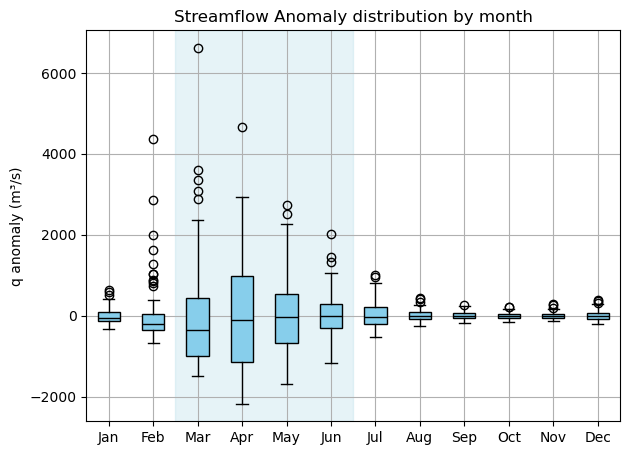

In [239]:
df = streamflow_anom.to_dataframe().reset_index()
df['month'] = df['time'].dt.month

plt.figure(figsize=(10, 6))
df.boxplot(
    column='q',
    by='month',
    grid=True,
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),)

plt.title('Streamflow Anomaly distribution by month')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('q anomaly (m³/s)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.axvspan(7 - 0.5, 2 + 0.5, color='lightblue', alpha=0.3)
plt.tight_layout()

 è coerente con il comportamento idrologico tipico dei bacini dell'Africa sud-orientale come quello dello Zambezi.     Le piogge avvengono durante DJFM, ma la risposta del fiume (la portata) arriva con ritardo. DJFM è la stagione delle piogge MAMJ è la stagione di piena del fiume

In [240]:
# DJFM
djfm = streamflow_anom.sel(time=streamflow_anom['time.month'].isin([12, 1, 2, 3])) # rain season
djfm_mean = djfm.groupby('time.year').mean('time')

# JASO: let's see which indices influence the most these months
jaso = streamflow_anom.sel(time=streamflow_anom['time.month'].isin([7, 8, 9, 10])) # months I need to predict
jaso_mean = jaso.groupby('time.year').mean('time')

In [241]:
def seasonal_std(xarr, months):
    return xarr.sel(time=xarr['time.month'].isin(months)).std('time')

djfm_months = [12, 1, 2, 3]
std_q_djfm = seasonal_std(streamflow_anom, djfm_months)

stds_indices_djfm = {
    name.upper(): seasonal_std(getattr(data, name), djfm_months)
    for name, data in zip(data_names, data_list_time_cropped)}

jaso_months = [7, 8, 9, 10]
std_q_jaso = seasonal_std(streamflow_anom, jaso_months)

stds_indices_jaso = {
    name.upper(): seasonal_std(getattr(data, name), jaso_months)
    for name, data in zip(data_names, data_list_time_cropped)}


#### DJFM

In [242]:
lag_list = [1, 2, 3, 4, 5, 6]
djfm_months = [12, 1, 2, 3]

# Resample a dati mensili
monthly_streamflow = streamflow_anom.resample(time='MS').mean('time')

# Filtra per DJFM
monthly_streamflow_djfm = monthly_streamflow.sel(time=monthly_streamflow['time.month'].isin(djfm_months))

# Inizializza DataFrame risultati
df_corr_anom_djfm = pd.DataFrame(index=lag_list, columns=data_names, dtype=float)
df_pval_anom_djfm = pd.DataFrame(index=lag_list, columns=data_names, dtype=float)

# Loop sugli indici climatici
for i, ds in enumerate(data_list_time_cropped):
    nome = data_names[i]

    climate_index = ds[nome].resample(time='MS').mean('time')

    # Allineamento temporale base
    sf_aligned, ci_aligned = xr.align(monthly_streamflow_djfm, climate_index, join='inner')

    for lag in lag_list:
        # Shifta l'indice climatico per simulare effetto anticipato
        ci_lagged = ci_aligned.shift(time=lag)

        # Maschera NaN
        mask = (~np.isnan(sf_aligned)) & (~np.isnan(ci_lagged))
        sf_masked = sf_aligned.where(mask, drop=True)
        ci_masked = ci_lagged.where(mask, drop=True)

        if sf_masked.time.size > 0 and ci_masked.time.size > 0:
            corr = xr.corr(sf_masked, ci_masked, dim='time').values
            pval = signif(sf_masked, ci_masked, lag=lag)  # Usa la tua funzione di significatività
        else:
            corr = np.nan
            pval = np.nan

        df_corr_anom_djfm.loc[lag, nome] = np.round(corr, 2)
        df_pval_anom_djfm.loc[lag, nome] = np.round(pval, 2)

# Stampa risultati
print("Correlazioni laggate (DJFM):")
print(df_corr_anom_djfm)

print("\nP-value correlazioni laggate (DJFM):")
print(df_pval_anom_djfm)

Correlazioni laggate (DJFM):
    dmi   mei   nao  nino3  nino4  nino12  nino34   pdo   soi   tsa
1  0.13 -0.03 -0.11  -0.05  -0.02   -0.03   -0.03 -0.15  0.02 -0.05
2  0.10 -0.05 -0.06  -0.04  -0.02   -0.06   -0.03 -0.15  0.00 -0.05
3  0.12 -0.10 -0.05  -0.05  -0.07   -0.05   -0.05 -0.16  0.09 -0.03
4  0.16 -0.15 -0.08  -0.08  -0.11   -0.02   -0.09 -0.24  0.08 -0.05
5  0.13 -0.16 -0.08  -0.10  -0.11   -0.08   -0.10 -0.25  0.12 -0.07
6  0.11 -0.17 -0.00  -0.14  -0.12   -0.14   -0.12 -0.25  0.14 -0.07

P-value correlazioni laggate (DJFM):
     dmi    mei    nao  nino3  nino4  nino12  nino34     pdo    soi    tsa
1  98.58  41.78  95.72  66.02  23.09   45.57   43.69   99.50  25.04  69.46
2  92.93  64.30  74.45  61.32  31.19   73.19   45.62   99.58   3.78  63.22
3  97.48  92.71  70.76  68.31  81.05   63.83   70.51   99.71  92.81  46.79
4  99.81  99.36  87.46  85.99  96.28   23.99   92.62  100.00  88.55  66.66
5  98.72  99.62  87.18  94.29  96.25   87.39   95.48  100.00  97.46  84.63
6  96.4

In [243]:
for col in df_corr_anom_djfm.columns:

    serie = df_corr_anom_djfm[col] #  Etract column of values
    lag_max = serie.abs().idxmax() # Find lag with maximum absolute value
    corr_max = serie.loc[lag_max] # Find the corresponding value (with sign)
    
    print(f"Highest (absolute) correlation for index {col} is {corr_max:.2f} at lag {lag_max} with p-value {df_pval_anom_djfm.loc[lag_max, col]:.2f} %")

Highest (absolute) correlation for index dmi is 0.16 at lag 4 with p-value 99.81 %
Highest (absolute) correlation for index mei is -0.17 at lag 6 with p-value 99.74 %
Highest (absolute) correlation for index nao is -0.11 at lag 1 with p-value 95.72 %
Highest (absolute) correlation for index nino3 is -0.14 at lag 6 with p-value 99.38 %
Highest (absolute) correlation for index nino4 is -0.12 at lag 6 with p-value 97.41 %
Highest (absolute) correlation for index nino12 is -0.14 at lag 6 with p-value 99.25 %
Highest (absolute) correlation for index nino34 is -0.12 at lag 6 with p-value 98.02 %
Highest (absolute) correlation for index pdo is -0.25 at lag 5 with p-value 100.00 %
Highest (absolute) correlation for index soi is 0.14 at lag 6 with p-value 99.24 %
Highest (absolute) correlation for index tsa is -0.07 at lag 5 with p-value 84.63 %


### JASO

In [244]:
lag_list = [-1, -2, -3, -4, -5, -6]  # LAG PASSATO: mesi prima della portata
jaso_months = [7, 8, 9, 10]  # Mesi target

# Resample a dati mensili
monthly_streamflow = streamflow_anom.resample(time='MS').mean('time')

# Filtra per i mesi target JASO
monthly_streamflow_jaso = monthly_streamflow.sel(time=monthly_streamflow['time.month'].isin(jaso_months))

# Inizializza DataFrame risultati
df_corr_anom_jaso = pd.DataFrame(index=lag_list, columns=data_names, dtype=float)
df_pval_anom_jaso = pd.DataFrame(index=lag_list, columns=data_names, dtype=float)

# Loop sugli indici climatici
for i, ds in enumerate(data_list_time_cropped):
    nome = data_names[i]

    climate_index = ds[nome].resample(time='MS').mean('time')

    # Allineamento temporale base
    sf_aligned, ci_aligned = xr.align(monthly_streamflow_jaso, climate_index, join='inner')

    for lag in lag_list:
        # NOTA: lag < 0 ⇒ guarda mesi precedenti ⇒ shift(time = -lag)
        ci_lagged = ci_aligned.shift(time=-lag)  

        # Maschera NaN
        mask = (~np.isnan(sf_aligned)) & (~np.isnan(ci_lagged))
        sf_masked = sf_aligned.where(mask, drop=True)
        ci_masked = ci_lagged.where(mask, drop=True)

        if sf_masked.time.size > 0 and ci_masked.time.size > 0:
            corr = xr.corr(sf_masked, ci_masked, dim='time').values
            pval = signif(sf_masked, ci_masked, lag=abs(lag))  # usa valore assoluto per test
        else:
            corr = np.nan
            pval = np.nan

        df_corr_anom_jaso.loc[lag, nome] = np.round(corr, 2)
        df_pval_anom_jaso.loc[lag, nome] = np.round(pval, 2)

# Stampa risultati
print("Correlazioni laggate (JASO, lag negativi = mesi prima):")
print(df_corr_anom_jaso)

print("\nP-value correlazioni laggate (JASO, mesi precedenti):")
print(df_pval_anom_jaso)


Correlazioni laggate (JASO, lag negativi = mesi prima):
     dmi   mei   nao  nino3  nino4  nino12  nino34   pdo   soi   tsa
-1 -0.05 -0.16 -0.04  -0.11  -0.18   -0.12   -0.12 -0.18  0.14 -0.01
-2 -0.06 -0.17  0.08  -0.14  -0.16   -0.15   -0.14 -0.18  0.18 -0.02
-3 -0.03 -0.20  0.04  -0.12  -0.16   -0.13   -0.14 -0.17  0.18  0.02
-4 -0.01 -0.24 -0.01  -0.12  -0.17   -0.14   -0.13 -0.22  0.23  0.02
-5 -0.02 -0.15  0.03  -0.08  -0.12   -0.10   -0.07 -0.18  0.17 -0.02
-6  0.02 -0.12  0.07  -0.05  -0.11   -0.07   -0.05 -0.18  0.14 -0.05

P-value correlazioni laggate (JASO, mesi precedenti):
      dmi     mei    nao  nino3  nino4  nino12  nino34     pdo     soi    tsa
-1  65.49   99.50  57.95  96.51  99.92   98.01   98.20   99.94   99.19  12.98
-2  74.34   99.76  86.20  99.21  99.83   99.57   99.26   99.90   99.92  24.30
-3  38.16   99.96  56.89  98.39  99.83   99.06   99.14   99.90   99.96  23.57
-4  21.22  100.00  22.41  98.12  99.87   99.39   98.80  100.00  100.00  24.12
-5  24.11   99.3

In [245]:
for col in df_corr_anom_jaso.columns:

    serie = df_corr_anom_jaso[col] #  Etract column of values
    lag_max = serie.abs().idxmax() # Find lag with maximum absolute value
    corr_max = serie.loc[lag_max] # Find the corresponding value (with sign)
    
    print(f"Highest (absolute) correlation for index {col} is {corr_max:.2f} at lag {lag_max} with p-value {df_pval_anom_jaso.loc[lag_max, col]:.2f} %")

Highest (absolute) correlation for index dmi is -0.06 at lag -2 with p-value 74.34 %
Highest (absolute) correlation for index mei is -0.24 at lag -4 with p-value 100.00 %
Highest (absolute) correlation for index nao is 0.08 at lag -2 with p-value 86.20 %
Highest (absolute) correlation for index nino3 is -0.14 at lag -2 with p-value 99.21 %
Highest (absolute) correlation for index nino4 is -0.18 at lag -1 with p-value 99.92 %
Highest (absolute) correlation for index nino12 is -0.15 at lag -2 with p-value 99.57 %
Highest (absolute) correlation for index nino34 is -0.14 at lag -2 with p-value 99.26 %
Highest (absolute) correlation for index pdo is -0.22 at lag -4 with p-value 100.00 %
Highest (absolute) correlation for index soi is 0.23 at lag -4 with p-value 100.00 %
Highest (absolute) correlation for index tsa is -0.05 at lag -6 with p-value 64.78 %
